In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#plt.style.use('fivethirtyeight')
import xgboost as xgb
import sklearn
import random
from NecessaryModules.getData import getData

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
# from NecessaryModules.splitData import split_data

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [3]:
filename = '../shot_listed_dataset/CoverTypeNewNormalized.csv'
dataset=getData(filename).values.tolist()
random.shuffle(dataset)
dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
# print(dataset)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.850622  0.105556  0.150943                          0.045351   
1   0.879149  0.163889  0.188679                          0.426304   
2   0.767116  0.327778  0.320755                          0.068027   
3   0.791494  0.338889  0.226415                          0.294785   
4   0.867220  0.575000  0.584906                          0.385488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.003509                         0.631060   
1                        0.189474                         0.177358   
2                        0.038596                         0.259652   
3                       -0.077193                         0.085486   
4                        0.314035                         0.074020   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.866142        0.874016          0.548   
1       0.897638        0.866142          0.500   
2    

In [4]:
def split_data(data):
    # splitting the data
    
    msk = np.random.rand(len(data)) < 0.7
    yy = [54] #test title is 54 after suffleing the dataframe 
    train = data[msk]
    test = data[~msk]
    x_train = train[train.columns[:train.shape[1] - 1]]  # all columns except the last are x variables
    y_train = train[yy[0]].tolist()  # the last column as y variable
    x_test = test[test.columns[:test.shape[1] - 1]]
    y_test = test[yy[0]].tolist()  # the last column as y variable
    y_train = [0 if i == 7 else i for i in y_train]  # replace label 7 with 0
    y_test = [0 if i == 7 else i for i in y_test]  # replace label 7 with 0
    return x_train, y_train, x_test, y_test

# RFE implement

In [5]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]

In [6]:
estimator = SVR(kernel="linear")
model = RFE(estimator, n_features_to_select=40, step=1)
rfeTrain = model.fit(X,y)
print(rfeTrain)

compressed_dataset_X= rfeTrain.transform(X)
print(type(compressed_dataset_X))
print(len(compressed_dataset_X))
print(compressed_dataset_X)


RFE(estimator=SVR(kernel='linear'), n_features_to_select=40)
<class 'numpy.ndarray'>
19229
[[0.89859959 0.         0.         ... 0.         0.         1.        ]
 [0.72121369 0.         0.         ... 0.         0.         0.        ]
 [0.57079875 1.         0.         ... 0.         0.         0.        ]
 ...
 [0.70046681 0.         0.         ... 0.         0.         0.        ]
 [0.72536307 0.         0.         ... 0.         0.         0.        ]
 [0.83532158 0.         0.         ... 0.         0.         0.        ]]


In [7]:
# from NecessaryModules.splitData import split_data
X_train, y_train, X_test, y_test = split_data(dataset)
print(len(X_train))

13482


In [8]:
compressed_dataset_X_train= rfeTrain.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= rfeTrain.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
13482
[[0.89859959 0.         0.         ... 0.         0.         1.        ]
 [0.72121369 0.         0.         ... 0.         0.         0.        ]
 [0.57079875 1.         0.         ... 0.         0.         0.        ]
 ...
 [0.5840249  1.         0.         ... 0.         0.         0.        ]
 [0.72536307 0.         0.         ... 0.         0.         0.        ]
 [0.83532158 0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'>
5747
[[0.71706432 0.         0.         ... 0.         0.         0.        ]
 [0.73910788 0.         0.         ... 0.         0.         0.        ]
 [0.64937759 1.         0.         ... 0.         0.         0.        ]
 ...
 [0.67842324 0.         0.         ... 0.         0.         0.        ]
 [0.76374481 0.         0.         ... 0.         0.         0.        ]
 [0.70046681 0.         0.         ... 0.         0.         0.        ]]


# tune XG Boost

In [9]:
# train the model with random parameter

# Preparing the regressor and fitting data with some parameters
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 1, 
                          learning_rate = 0.3,
                          max_depth = 15, 
                          alpha = 10, 
                          n_estimators = 100, 
                          verbose=1, 
                          min_child_weight = 1, 
                          colsample_bylevel = 1, 
                          reg_alpha = 2) 

xg_reg.fit(compressed_dataset_X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# Finding mean absolute error
preds = xg_reg.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.8261701757438664

In [11]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(compressed_dataset_X)
target_train_tunned = np.array(y)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(compressed_dataset_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [1e-5,1e-4,1e-3,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.04,0.08,0.12,0.20, 0.24, 0.30, 0.38, 0.42, 0.48, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]),
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20,25,30,35,40]),
            'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    model = xgb.XGBRegressor(**param)  
        
    model.fit(train_X,train_Y,eval_set=[(valid_X,valid_Y)],early_stopping_rounds=100,verbose=False)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [12]:
# this is the main optuna for optimizing a object-->"objective"
study = optuna.create_study(direction='minimize',study_name="XG_tune")

[I 2024-02-20 09:09:02,683] A new study created in memory with name: XG_tune


In [13]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-20 09:09:05,569] Trial 0 finished with value: 1.0274839737565464 and parameters: {'lambda': 1.2535835349212545, 'alpha': 4.268645245691248, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.24, 'n_estimators': 126, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 22}. Best is trial 0 with value: 1.0274839737565464.


19229


[I 2024-02-20 09:09:07,579] Trial 1 finished with value: 1.0878289259799316 and parameters: {'lambda': 0.29997277913763953, 'alpha': 0.6835470999311467, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 0.5, 'learning_rate': 0.8, 'n_estimators': 62, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 181}. Best is trial 0 with value: 1.0274839737565464.


19229


[I 2024-02-20 09:09:17,033] Trial 2 finished with value: 1.1218274289133694 and parameters: {'lambda': 0.0815096095076333, 'alpha': 0.00567400462702848, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 286, 'max_depth': 30, 'random_state': 2020, 'min_child_weight': 94}. Best is trial 0 with value: 1.0274839737565464.


19229


[I 2024-02-20 09:09:17,599] Trial 3 finished with value: 1.7035664273930127 and parameters: {'lambda': 0.00742538002973769, 'alpha': 0.035163547639964855, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'subsample': 0.6, 'learning_rate': 0.003, 'n_estimators': 20, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 257}. Best is trial 0 with value: 1.0274839737565464.


19229


[I 2024-02-20 09:09:22,488] Trial 4 finished with value: 1.0381490776062607 and parameters: {'lambda': 0.007665159577256371, 'alpha': 0.00622387057841511, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.5, 'n_estimators': 211, 'max_depth': 40, 'random_state': 2020, 'min_child_weight': 219}. Best is trial 0 with value: 1.0274839737565464.


19229


[I 2024-02-20 09:09:28,967] Trial 5 finished with value: 1.0017751558093944 and parameters: {'lambda': 0.001508084621131044, 'alpha': 0.01214672469741124, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 272, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 159}. Best is trial 5 with value: 1.0017751558093944.


19229


[I 2024-02-20 09:09:33,200] Trial 6 finished with value: 0.9963347075442242 and parameters: {'lambda': 0.10881191097036837, 'alpha': 0.0022919668111286624, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.7, 'n_estimators': 162, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 62}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:09:35,476] Trial 7 finished with value: 1.0478319737755495 and parameters: {'lambda': 6.449238924302175, 'alpha': 0.010606646334491284, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.7, 'n_estimators': 106, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 146}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:09:37,966] Trial 8 finished with value: 1.5868871291606597 and parameters: {'lambda': 0.3499195823862201, 'alpha': 0.1354754985438479, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'subsample': 0.6, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 190}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:09:43,708] Trial 9 finished with value: 1.4329448604281207 and parameters: {'lambda': 0.10515994498193904, 'alpha': 0.2239658305133852, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.005, 'n_estimators': 286, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 23}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:09:48,007] Trial 10 finished with value: 1.658340023747906 and parameters: {'lambda': 9.852446359332854, 'alpha': 0.0010553581148535476, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 199, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 86}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:09:53,241] Trial 11 finished with value: 1.003991486591757 and parameters: {'lambda': 0.0028394662177850588, 'alpha': 0.0011368780256351496, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.7, 'n_estimators': 212, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 111}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:09:59,289] Trial 12 finished with value: 1.0411961215248755 and parameters: {'lambda': 0.0011867299262816615, 'alpha': 0.021173113285765197, 'colsample_bytree': 0.8, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 244, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 296}. Best is trial 6 with value: 0.9963347075442242.


19229


[I 2024-02-20 09:10:05,212] Trial 13 finished with value: 0.9883109035448051 and parameters: {'lambda': 0.02972189874036882, 'alpha': 0.00278737962713191, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.38, 'n_estimators': 160, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 58}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:10,470] Trial 14 finished with value: 1.010567095863186 and parameters: {'lambda': 0.029661785720738687, 'alpha': 0.002341844185856764, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.9, 'n_estimators': 162, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 55}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:20,870] Trial 15 finished with value: 0.9967908855285279 and parameters: {'lambda': 0.025926130278689147, 'alpha': 0.060917647074786384, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 169, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 6}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:23,876] Trial 16 finished with value: 1.453934333918216 and parameters: {'lambda': 0.9272065417561909, 'alpha': 0.0033632367570278795, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 143, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 58}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:25,636] Trial 17 finished with value: 1.065575695369435 and parameters: {'lambda': 0.0319277738557165, 'alpha': 9.03904807445376, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 1.0, 'n_estimators': 71, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 124}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:29,359] Trial 18 finished with value: 1.7109134471498926 and parameters: {'lambda': 0.15466645209278343, 'alpha': 0.4044918986554262, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 184, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 59}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:35,902] Trial 19 finished with value: 1.0079763600235332 and parameters: {'lambda': 0.008262952519608175, 'alpha': 1.3949092029859356, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 246, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 76}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:38,791] Trial 20 finished with value: 1.3800591116508496 and parameters: {'lambda': 1.859501467930975, 'alpha': 0.0025848862544926485, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.006, 'n_estimators': 134, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 32}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:10:54,422] Trial 21 finished with value: 1.0207321982443491 and parameters: {'lambda': 0.03644030404641608, 'alpha': 0.07013343419984101, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 169, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 1}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:11:00,205] Trial 22 finished with value: 0.9941038906983413 and parameters: {'lambda': 0.014029404983754372, 'alpha': 0.041305721018452396, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 177, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 41}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:11:06,888] Trial 23 finished with value: 0.9953563048737402 and parameters: {'lambda': 0.016636100235230183, 'alpha': 0.023681992932300937, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.2, 'n_estimators': 225, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 48}. Best is trial 13 with value: 0.9883109035448051.


19229


[I 2024-02-20 09:11:16,046] Trial 24 finished with value: 0.9860470809971984 and parameters: {'lambda': 0.014090295531805857, 'alpha': 0.03966817263585016, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 248, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 40}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:23,328] Trial 25 finished with value: 0.9943204357351402 and parameters: {'lambda': 0.00332796617823507, 'alpha': 0.14898484065927492, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.3, 'n_estimators': 252, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 104}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:28,735] Trial 26 finished with value: 1.0411929754045628 and parameters: {'lambda': 0.016656376711445663, 'alpha': 0.0377090785012317, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 182, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 130}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:35,460] Trial 27 finished with value: 1.1562321124009145 and parameters: {'lambda': 0.0030656171553000732, 'alpha': 0.008949561584605765, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.007, 'n_estimators': 227, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 35}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:37,934] Trial 28 finished with value: 1.0218751106156072 and parameters: {'lambda': 0.055943229348814405, 'alpha': 0.01965809746101107, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.42, 'n_estimators': 111, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 77}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:43,366] Trial 29 finished with value: 1.7141483024090498 and parameters: {'lambda': 0.012514556557147383, 'alpha': 1.0845897118355428, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1e-05, 'n_estimators': 194, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 21}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:49,615] Trial 30 finished with value: 1.4483723051245843 and parameters: {'lambda': 0.006769540820642971, 'alpha': 0.3581502642260328, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 262, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 42}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:11:57,240] Trial 31 finished with value: 1.003074910281892 and parameters: {'lambda': 0.003112696157427555, 'alpha': 0.18814736496724013, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.12, 'n_estimators': 253, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 104}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:00,381] Trial 32 finished with value: 1.372599012636346 and parameters: {'lambda': 0.003338151443917867, 'alpha': 0.10354348861198344, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.5, 'learning_rate': 0.009, 'n_estimators': 126, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 67}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:07,340] Trial 33 finished with value: 0.993057324818252 and parameters: {'lambda': 0.005123900114288471, 'alpha': 0.05294027006299411, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.3, 'n_estimators': 296, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 91}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:14,988] Trial 34 finished with value: 0.9877807626244901 and parameters: {'lambda': 0.04867307993347466, 'alpha': 0.05030914496073345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.08, 'n_estimators': 292, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 20}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:21,912] Trial 35 finished with value: 0.9861385067915655 and parameters: {'lambda': 0.041866784352641885, 'alpha': 0.06778779923689668, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.08, 'n_estimators': 297, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 16}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:29,310] Trial 36 finished with value: 0.9875742466433991 and parameters: {'lambda': 0.058304447406764576, 'alpha': 0.005615094873090563, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 276, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 13}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:40,341] Trial 37 finished with value: 0.988609767538553 and parameters: {'lambda': 0.20842927441983805, 'alpha': 0.004896217014990149, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 15}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:47,991] Trial 38 finished with value: 0.9940299545090001 and parameters: {'lambda': 0.06475584416432277, 'alpha': 0.01535058594708839, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 271, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 4}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:12:55,407] Trial 39 finished with value: 0.9908160014385379 and parameters: {'lambda': 0.2990702647467987, 'alpha': 0.02897439758904397, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 278, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 19}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:00,789] Trial 40 finished with value: 1.0843143250679497 and parameters: {'lambda': 0.07796305194741188, 'alpha': 0.09655908986925782, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 230, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 223}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:01,731] Trial 41 finished with value: 1.7045935505395797 and parameters: {'lambda': 0.045489880702300166, 'alpha': 0.006751276605956119, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 20, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 32}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:09,847] Trial 42 finished with value: 0.998142546676016 and parameters: {'lambda': 0.022464975515099628, 'alpha': 0.004718688699700702, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.08, 'n_estimators': 288, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 25}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:13,488] Trial 43 finished with value: 1.0037657793475094 and parameters: {'lambda': 0.14260547093493128, 'alpha': 0.0016897233377421055, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.8, 'n_estimators': 268, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 11}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:19,796] Trial 44 finished with value: 1.1423666979917046 and parameters: {'lambda': 0.047908075484263, 'alpha': 0.012773128752055505, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 286, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 48}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:21,987] Trial 45 finished with value: 1.6832529746262963 and parameters: {'lambda': 0.0963174149748077, 'alpha': 0.2666490417557717, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 60, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 24}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:27,345] Trial 46 finished with value: 1.0593180137011902 and parameters: {'lambda': 0.009447916234043507, 'alpha': 0.008704484301980448, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.24, 'n_estimators': 279, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 161}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:32,595] Trial 47 finished with value: 1.0461107694285603 and parameters: {'lambda': 0.02238377099008312, 'alpha': 0.0014840827378054505, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.38, 'n_estimators': 261, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 71}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:37,811] Trial 48 finished with value: 1.0478019633328612 and parameters: {'lambda': 0.04115272977817534, 'alpha': 0.08130720511634959, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 237, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 48}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:46,900] Trial 49 finished with value: 1.5998759910985816 and parameters: {'lambda': 0.57002453262576, 'alpha': 0.003653987172041958, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 214, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 1}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:13:54,084] Trial 50 finished with value: 1.5891075864076998 and parameters: {'lambda': 0.15722624601120413, 'alpha': 0.05024666301359762, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 289, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 300}. Best is trial 24 with value: 0.9860470809971984.


19229


[I 2024-02-20 09:14:04,557] Trial 51 finished with value: 0.982546384394451 and parameters: {'lambda': 0.1959491822126557, 'alpha': 0.004923479876533795, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 18}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:14,290] Trial 52 finished with value: 0.9896938406464536 and parameters: {'lambda': 0.2996705655206177, 'alpha': 0.018189717446023962, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 299, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 14}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:19,311] Trial 53 finished with value: 1.6065704970087273 and parameters: {'lambda': 0.07290709017029051, 'alpha': 0.006624905436204987, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 277, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 33}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:27,668] Trial 54 finished with value: 1.5684104209893752 and parameters: {'lambda': 0.11391934306218787, 'alpha': 0.0033257901224413326, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 261, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 58}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:33,411] Trial 55 finished with value: 1.0022965534607864 and parameters: {'lambda': 0.02850246862053735, 'alpha': 0.0018151400085528136, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.5, 'n_estimators': 283, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 84}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:35,769] Trial 56 finished with value: 1.568281096609652 and parameters: {'lambda': 0.527293537176906, 'alpha': 0.01288487277305017, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.004, 'n_estimators': 83, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 28}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:41,477] Trial 57 finished with value: 1.6410318402332946 and parameters: {'lambda': 0.21729822163776996, 'alpha': 0.029250710364664142, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 242, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 40}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:48,525] Trial 58 finished with value: 1.6024953964019542 and parameters: {'lambda': 0.011556274665124218, 'alpha': 0.12823507588544727, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 268, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 199}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:53,942] Trial 59 finished with value: 0.9991746748706977 and parameters: {'lambda': 0.03432296680743256, 'alpha': 0.001042937804252963, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.38, 'n_estimators': 293, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 13}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:14:58,924] Trial 60 finished with value: 1.626876346827781 and parameters: {'lambda': 0.02209067463273367, 'alpha': 0.002242252324823799, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 201, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 263}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:09,056] Trial 61 finished with value: 0.9880080304854286 and parameters: {'lambda': 0.1824555555653409, 'alpha': 0.004990106381215809, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 298, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 14}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:16,748] Trial 62 finished with value: 1.0187186373334647 and parameters: {'lambda': 0.06042019936627052, 'alpha': 0.0036196546837296323, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 254, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 50}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:23,680] Trial 63 finished with value: 1.4962493087430908 and parameters: {'lambda': 0.09451832865840229, 'alpha': 0.007584334501108471, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.003, 'n_estimators': 147, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 2}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:31,470] Trial 64 finished with value: 0.989630297650115 and parameters: {'lambda': 0.01768637327264663, 'alpha': 0.0052181253733213865, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 19}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:36,186] Trial 65 finished with value: 1.0237770958070944 and parameters: {'lambda': 0.45450864923774403, 'alpha': 0.010899964497777382, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.9, 'n_estimators': 276, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 35}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:42,235] Trial 66 finished with value: 1.7011465742123208 and parameters: {'lambda': 0.21524079525579923, 'alpha': 0.025628057188272664, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.0001, 'n_estimators': 287, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 13}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:48,777] Trial 67 finished with value: 1.6074537438481862 and parameters: {'lambda': 0.14112385273421385, 'alpha': 0.041883604820886315, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 267, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 62}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:15:55,650] Trial 68 finished with value: 1.5906631799388697 and parameters: {'lambda': 0.0534376895346916, 'alpha': 0.696798801970812, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 292, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 40}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:16:02,549] Trial 69 finished with value: 1.229275458520769 and parameters: {'lambda': 0.03870079147267632, 'alpha': 0.0023990254264771903, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 255, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 30}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:16:07,732] Trial 70 finished with value: 0.9834127878498328 and parameters: {'lambda': 0.8938090601494105, 'alpha': 0.06686399701738217, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 156, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:16:15,274] Trial 71 finished with value: 1.3168692530035333 and parameters: {'lambda': 2.060178276842411, 'alpha': 0.07365361758863154, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.005, 'n_estimators': 159, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:16:20,780] Trial 72 finished with value: 1.6271801593864235 and parameters: {'lambda': 0.8534371043989105, 'alpha': 0.137782697446293, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 137, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 22}. Best is trial 51 with value: 0.982546384394451.


19229


[I 2024-02-20 09:16:27,301] Trial 73 finished with value: 0.9818173206428593 and parameters: {'lambda': 2.057194053601899, 'alpha': 0.05778709512851281, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 281, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 12}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:16:39,128] Trial 74 finished with value: 1.5447030774305526 and parameters: {'lambda': 3.4954742314552103, 'alpha': 0.052073735929911616, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 278, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:16:42,494] Trial 75 finished with value: 0.9875787199256486 and parameters: {'lambda': 2.7337574042900874, 'alpha': 0.03193554788830737, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 300, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 22}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:16:46,044] Trial 76 finished with value: 0.9894755385935049 and parameters: {'lambda': 4.91471508028933, 'alpha': 0.03504263030406782, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 283, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 25}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:16:52,026] Trial 77 finished with value: 0.9855311232328824 and parameters: {'lambda': 2.034260558906116, 'alpha': 0.10871329300407613, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.08, 'n_estimators': 246, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:16:56,402] Trial 78 finished with value: 0.9984417774751484 and parameters: {'lambda': 1.6257851898949596, 'alpha': 0.09801939643000941, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 247, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 41}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:16:59,352] Trial 79 finished with value: 0.9834874182043708 and parameters: {'lambda': 2.6952874850420168, 'alpha': 0.20410436881664276, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 236, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:17:04,701] Trial 80 finished with value: 1.5943643297641497 and parameters: {'lambda': 8.697260445462037, 'alpha': 0.18920977739086955, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 218, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:17:07,674] Trial 81 finished with value: 0.9848695902074516 and parameters: {'lambda': 2.694320587559337, 'alpha': 0.2870172061837003, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 237, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:17:12,957] Trial 82 finished with value: 1.590550312628159 and parameters: {'lambda': 1.3998042596270228, 'alpha': 0.33981301403480996, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 221, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 6}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:17:18,449] Trial 83 finished with value: 1.585491648887818 and parameters: {'lambda': 0.9183109084389719, 'alpha': 0.21679735028361335, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 231, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 73 with value: 0.9818173206428593.


19229


[I 2024-02-20 09:17:21,916] Trial 84 finished with value: 0.9790188644463589 and parameters: {'lambda': 4.180728077846551, 'alpha': 0.5898239839335102, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 241, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:25,572] Trial 85 finished with value: 0.9955665946372543 and parameters: {'lambda': 4.324392095211124, 'alpha': 0.762669256331848, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 209, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:28,788] Trial 86 finished with value: 0.9889309764345448 and parameters: {'lambda': 2.399435326453945, 'alpha': 0.5034164644592316, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 233, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:34,537] Trial 87 finished with value: 1.5814010644642225 and parameters: {'lambda': 3.160984557280565, 'alpha': 2.141991417683193, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 241, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:39,370] Trial 88 finished with value: 0.9949758766142786 and parameters: {'lambda': 1.1726054005345152, 'alpha': 0.3066568130441956, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 190, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 47}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:43,286] Trial 89 finished with value: 0.9874541250841313 and parameters: {'lambda': 6.075269954930142, 'alpha': 0.49037216276890294, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.6, 'n_estimators': 249, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:47,079] Trial 90 finished with value: 1.6261042418795595 and parameters: {'lambda': 3.850258224326607, 'alpha': 0.1567229120671472, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 204, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 28}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:50,236] Trial 91 finished with value: 0.9996506196834521 and parameters: {'lambda': 5.790149902006549, 'alpha': 0.47817056456097806, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.6, 'n_estimators': 237, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:17:57,201] Trial 92 finished with value: 1.5630576021121156 and parameters: {'lambda': 7.793438596537709, 'alpha': 1.3370868205100497, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 260, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 16}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:03,717] Trial 93 finished with value: 1.1797172131618487 and parameters: {'lambda': 2.209532561643401, 'alpha': 0.25687002061929065, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.006, 'n_estimators': 247, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 25}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:13,042] Trial 94 finished with value: 1.7137723180580526 and parameters: {'lambda': 1.6783323700153518, 'alpha': 0.9005606992263006, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 1e-05, 'n_estimators': 225, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 7}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:18,258] Trial 95 finished with value: 1.6450956306440656 and parameters: {'lambda': 6.1481122239476855, 'alpha': 0.4447665220890958, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 253, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 37}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:24,481] Trial 96 finished with value: 1.6449061274261927 and parameters: {'lambda': 2.9275342615077617, 'alpha': 0.5862406023097749, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 266, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 17}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:25,689] Trial 97 finished with value: 1.006027367986013 and parameters: {'lambda': 5.260788307904416, 'alpha': 0.11569479117719976, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.6, 'n_estimators': 30, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 29}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:30,441] Trial 98 finished with value: 1.0364658438295808 and parameters: {'lambda': 1.3270312971282618, 'alpha': 0.062475917401967285, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.2, 'n_estimators': 240, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 125}. Best is trial 84 with value: 0.9790188644463589.


19229


[I 2024-02-20 09:18:38,046] Trial 99 finished with value: 1.1345464277083952 and parameters: {'lambda': 0.7281472938621605, 'alpha': 0.1608837294133791, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 249, 'max_depth': 25, 'random_state': 2020, 'min_child_weight': 138}. Best is trial 84 with value: 0.9790188644463589.


19229
Number of finished trials: 100
Best trial: {'lambda': 4.180728077846551, 'alpha': 0.5898239839335102, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 241, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 18}


In [14]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.9790188644463589
  Params: 
    lambda: 4.180728077846551
    alpha: 0.5898239839335102
    colsample_bytree: 1.0
    colsample_bylevel: 0.4
    subsample: 0.8
    learning_rate: 1.0
    n_estimators: 241
    max_depth: 9
    random_state: 2020
    min_child_weight: 18


# process the whole data

In [15]:
# filename_2 = '../shot_listed_dataset/Cover_type_whole_genuine_dataset_normalization.csv'
# dataset_2=getData(filename_2).values.tolist()
# random.shuffle(dataset_2)

# dataset_2=pd.DataFrame(dataset_2) #from dataset_list to dataset_dataframe after suffling
# print(dataset_2)

In [16]:
# # checking for NaN value
# result = dataset_2.columns[dataset_2.isna().any()].tolist()
# result

In [17]:
# X_2=dataset_2.iloc[:,0:-1]
# y_2=dataset_2.iloc[:,-1]
# X_train_2, y_train_2, X_test_2, y_test_2 = split_data(dataset_2)

In [18]:
# estimator = SVR(kernel="linear")
# model = RFE(estimator, n_features_to_select=30, step=1)
# rfeTrain_2 = model.fit(X_2,y_2)# --train-- pca with the "dataset" Dataframe
# print(rfeTrain_2)
# compressed_dataset_X_2 = rfeTrain.transform(X_2) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters


# compressed_dataset_X_train_2= rfeTrain.transform(X_train_2) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
# print(type(compressed_dataset_X_train_2))
# print(len(compressed_dataset_X_train_2))


# compressed_dataset_X_test_2= rfeTrain.transform(X_test_2) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
# print(type(compressed_dataset_X_test_2))
# print(len(compressed_dataset_X_test_2))


# fit the XG-Boost

In [19]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [20]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(compressed_dataset_X_train)
target_train = np.array(y_train)

test = np.array(compressed_dataset_X_test)
# target_train = df_train['congestion'].values

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(compressed_dataset_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    xgb_params = study.best_trial.params
    model_xb = xgb.XGBRegressor(**xgb_params)
    model_xb.fit(train_X, train_y,eval_set=[(valid_X,valid_y)],early_stopping_rounds=100,verbose=False)
    # for train accuracy
    preds = model_xb.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model_xb.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

0.7288542415115978


In [21]:
#validation accuracy
# target_test = np.array(y_test_2)
from sklearn.metrics import accuracy_score


valid_Acc=accuracy_score(target_train,oof_preds.round())
print(valid_Acc)

0.5003708648568461


In [22]:
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_xb=accuracy_score(target_test,test_preds.round())
print(test_Acc_xb)

0.4899947798851575


In [23]:
# train accuracy
train_Acc=model_xb.score(compressed_dataset_X_train,y_train)
print(train_Acc)

0.7600279749856768


In [24]:
# test_accuracy
test_Acc=model_xb.score(compressed_dataset_X_test,y_test)
print(test_Acc)

0.7253008945257651


# confusion matrix

In [25]:
from sklearn.base import is_classifier


is_classifier(model_xb) # because XGBoost is not included in sklearn

False

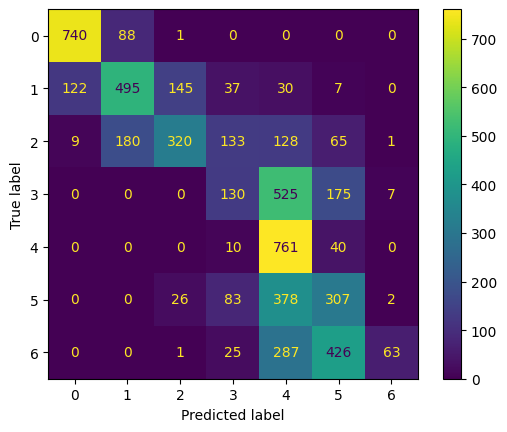

In [26]:
############# plot confusion matrix ############

from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.pink)


In [27]:
# print(cm[0][0])

In [28]:
# cm[0,0]

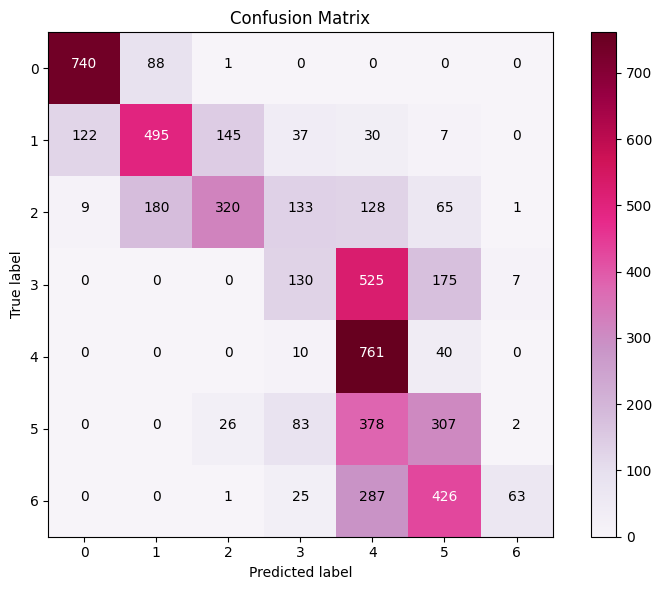

In [29]:
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding ticks and labels
# tick_marks = np.arange(len(cm))
# plt.xticks(tick_marks, ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','class 5','class 6'])
# plt.yticks(tick_marks, ['Class 0', 'Class 1', 'Class 2'])

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()